# First part of homework 4

In this part I will train a model using transfer learning

In [1]:
# imports

import os, random

import numpy as np

import optuna
import optuna.visualization as vis

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision.models import ResNet50_Weights, MobileNet_V3_Small_Weights
from torch.utils.data import DataLoader, Subset, Dataset


I have downloaded the images using the [OIDv4_ToolKit](https://github.com/EscVM/OIDv4_ToolKit.git), which is a tool to download images from Google Open Images Dataset.

For simplicity, I have already downloaded the images and uploaded them to a git repository.

In [2]:
# config class

class CFG:
    def __init__(self):
        
        self.seed = 42
        
        self.data_dir = "data"
        
        self.num_classes = 3 # number of classes in the dataset
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.epochs = 30 # number of epochs
        self.hyperopt_epochs = 15
        self.lr_start = 0.01 # start learning rate
        self.batch_size = 32 # batch size
        
        self.augment_threshold = 0.33 # threshold for an augmentation to be applied
        
        self.optim = "sgd" # It was painful to try AdamW for days and days... That's a lesson for sure!
        
        self.model = "mobilenet_v3_small" # model to use. 'resnet50' or 'mobilenet_v3_small'
        
        self.model_name = "model.pth" # model name to save
        
        self.dont_freeze = False # freeze the model or not
        
        self.load_checkpoint = False # load checkpoint or not
        
        self.num_workers = 6
        
        
        # setting the image size based on the model      
        if self.model == "resnet50":
            self.imgsize = (232,232)
        elif self.model == "mobilenet_v3_small":
            self.imgsize = (224,224)    
        
        
    
cfg = CFG()

In [3]:
# setting seeds

os.environ["PYTHONHASHSEED"] = str(cfg.seed)
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
random.seed(cfg.seed)
np.random.seed(cfg.seed)
torch.manual_seed(cfg.seed)
torch.use_deterministic_algorithms(True)
torch.cuda.manual_seed(cfg.seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
# define base transforms

base_transform = transforms.Compose([
    transforms.Resize(cfg.imgsize),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]) # These are the mean and std values from the imagenet competition.
])

dataset = datasets.ImageFolder(root=cfg.data_dir, transform=base_transform) # read the images from the data directory


In [5]:
# create datsets
from collections import Counter
labels_of_the_dataset = [dataset.targets[i] for i in range(len(dataset))]

indices = list(range(len(dataset)))
train_idx, temp_idx = train_test_split(indices, test_size=0.5, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)

train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

In [6]:
# define augmentations

# I will apply one of them randomly upon use (see at the CustomAugmentedDataset)

augmentations = [
    transforms.RandomResizedCrop(cfg.imgsize),  # randomly crops and resizes the image to the specified size (cfg.imgsize), introducing variation in the spatial content.
    transforms.RandomPerspective(distortion_scale=0.5, p=1),  # applies a random perspective transformation to simulate changes in viewing angle.
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # randomly adjusts brightness, contrast, saturation, and hue for color variation in the image.
    transforms.RandomHorizontalFlip(p=1),  # flips the image horizontally, commonly used for mirroring.
    transforms.RandomVerticalFlip(p=1),  # flips the image vertically, introducing additional spatial variation.
    transforms.RandomRotation(degrees=10),  # rotates the image randomly within a range of ±10 degrees, simulating small rotations.
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),  # applies affine transformations, allowing random translations of up to 5% of the image size.
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 1.0))  # applies Gaussian blur with a kernel size of 3x3 and sigma chosen randomly in the range [0.1, 1.0], softening the image for robustness.
]


In [7]:
# class for a custom dataset, that augments the samples upon use. I chose this because the small amount of data that I could use

class CustomAugmentedDataset(Dataset):
    def __init__(self, dataset, augmentations):
        self.dataset = dataset
        self.augmentations = augmentations

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if random.random() > cfg.augment_threshold: # applies a single, randomly chosen augmentation from the augmentation pool. 
            transform = random.choice(self.augmentations)
            image = transform(image)
        return image, label

In [8]:
# create dataloaders

train_dataset = CustomAugmentedDataset(train_dataset, augmentations)

train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True, num_workers=cfg.num_workers)
val_loader = DataLoader(val_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)
test_loader = DataLoader(test_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.021011949..1.0044097].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.029000014..1.06056].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.029000014..1.0485862].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.017235309..0.88893473].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.021156877..1.06056].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.013313711..1.0445949].


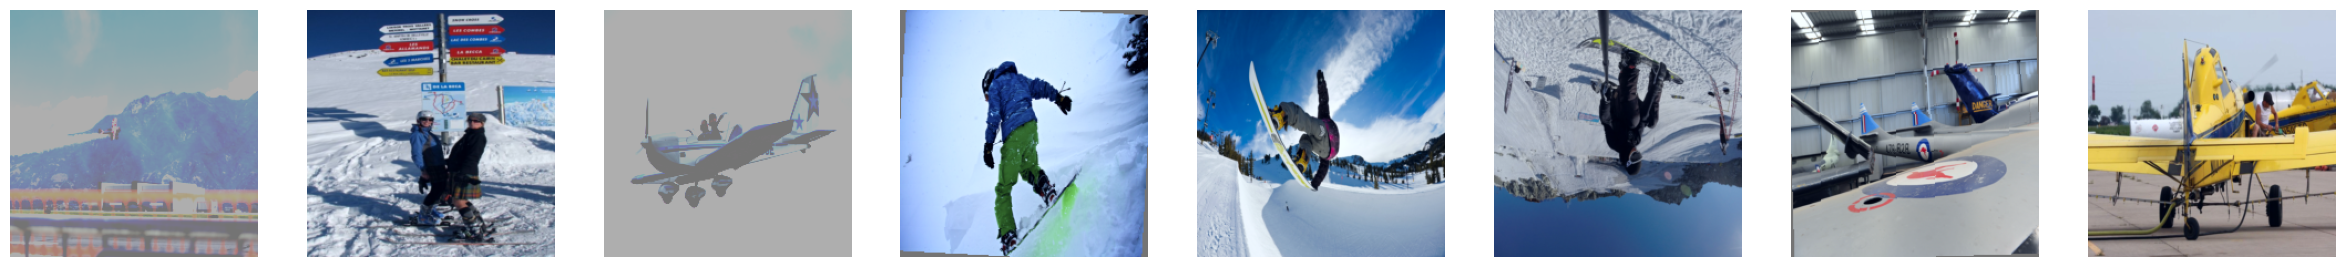

Train dataset size: 600
Validation dataset size: 300
Test dataset size: 300


In [9]:
# visualise some images

def visualise_images(dataloader):
    data_iter = iter(dataloader)
    images, labels = next(data_iter)

    fig, axes = plt.subplots(1, 8, figsize=(30, 10))
    for i in range(8):
        image = images[i].permute(1, 2, 0).numpy()
        axes[i].imshow(
            (image * 0.229 + 0.456
             )
            )
        axes[i].axis("off")
    plt.show()

visualise_images(train_loader)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

In [10]:
# define the model
# for the first training we want to freeze all the layers except the classifier layers.


if cfg.model == "mobilenet_v3_small":
    model = models.mobilenet_v3_small(weights=MobileNet_V3_Small_Weights)
    model.classifier[3] = nn.Linear(model.classifier[3].in_features, cfg.num_classes) # original classifier has too much output neurons
    
    if not cfg.dont_freeze:
        for param in model.features.parameters():
            param.requires_grad = False # we can freeze a layer by 'switching off' it's tensors requires_grad attribute
    
elif cfg.model == "resnet50":
    model = models.resnet50(weights=ResNet50_Weights)
    model.fc = nn.Linear(model.fc.in_features, cfg.num_classes) # original classifier has too much output neurons
    
    if not cfg.dont_freeze:
        for param in model.layer1.parameters():
            param.requires_grad = False
        for param in model.layer2.parameters():
            param.requires_grad = False
        for param in model.layer3.parameters():
            param.requires_grad = False
        for param in model.layer4.parameters():
            param.requires_grad = False
        
else:
    raise NotImplementedError("Bro pls")
   
model.to(cfg.device)

/home/pongvins/miniconda3/envs/depphw/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [11]:
# define the loss function, learning rate scheduler and the optimizer

criterion = nn.CrossEntropyLoss()
if cfg.optim == "adamw":
    optimizer = optim.AdamW(model.parameters(), lr = cfg.lr_start)
if cfg.optim == "adam":
    optimizer = optim.Adam(model.parameters(), lr = cfg.lr_start)
if cfg.optim == "sgd":
    optimizer = optim.SGD(model.parameters(), lr=cfg.lr_start, momentum=0.9, weight_decay=1e-4)
    
# I prefer the CosineAnnealingLR over a constant learningn rate.
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=cfg.epochs * 2)

train_accs = []; val_accs = []; lrs = []

In [12]:
# training loop

def train(train_accs, val_accs, lrs, epochparam=0):
    if cfg.load_checkpoint and os.path.exists(cfg.model_name) and epochparam == 0: # If we want to continue the training of a model
        model.load_state_dict(torch.load(cfg.model_name, weights_only=True))
        print(f'Model loaded from disk "{cfg.model_name}"')

    for epoch in range(cfg.epochs):
        model.train() # we need to make sure that the dropout layers are on
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for batch_idx, (images, labels) in enumerate(train_loader, start=1):
            images, labels = images.to(cfg.device), labels.to(cfg.device)
            
            optimizer.zero_grad() # zero the gradients before each batch
            
            outputs = model(images) # predicting labels

            loss = criterion(outputs, labels) # calculate the loss

            loss.backward() # backpropagate the gradients, so the optimizer knows how much it needs to adjust the weigths
            optimizer.step() # do the actual adjustment of the changes

            
            # calculate some metrics to get a better understanding what the model is doing while learning 
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

            avg_loss = running_loss / batch_idx
            print(f"Epoch [{epoch+1}/{cfg.epochs}], Batch [{batch_idx}/{len(train_loader)}], "
                f"Avg Train Loss: {avg_loss:.4f}", end='\r')

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        
        # validate the model after each epoch
        model.eval() # we need to make sure thet dropout is off in inference mode
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        # loop over the val_loader ot estimate the models performance
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(cfg.device), labels.to(cfg.device)
                outputs = model(images)
                
                val_loss += criterion(outputs, labels).item()
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)
        
        # some calculations
        val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct_val / total_val
        
        if epoch == 0 or (val_accuracy > max(val_accs)):
            torch.save(model.state_dict(), cfg.model_name)

        val_accs.append(val_accuracy)
        lrs.append(lr_scheduler.get_last_lr()[-1])
        train_accs.append(train_accuracy)
        
        # print the model's performance for each epoch
        print(f"Epoch [{epoch+1}/{cfg.epochs}], "
            f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
            f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, LR: {lr_scheduler.get_last_lr()[-1]:.5f}")
        
        # change the learning rate after each epoch vwith the CosineAnnealingLR
        lr_scheduler.step()
    
    # returning some metrics for further investigation
    return train_accs, val_accs, lrs, epoch+epochparam

In [ ]:
# function for testing the model

def test(train_accs, val_accs, lrs, epochnum, last_test=False):
    
    if last_test: # if it is the last test than we want to load the best performing model.
        model.load_state_dict(torch.load(cfg.model_name, weights_only=True))

    # Some plots:
    
    lin = list(range(epochnum))

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 8))

    ax1.plot(lin, val_accs, label='Validation Accuracy')
    ax1.plot(lin, train_accs, label='Training Accuracy')
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Accuracy")
    ax1.set_ylim(0, 100)
    ax1.legend()
    ax1.grid()

    ax2.plot(lin, lrs, label='Learning rate')
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Learning rate")
    ax2.legend()
    ax2.grid()

    ax3.plot(lin, lrs, label='Learning rate (log)')
    ax3.set_xlabel("Epochs")
    ax3.set_ylabel("Learning rate (log)")
    ax3.set_yscale("log")
    ax3.legend()
    ax3.grid()

    plt.show()
    
    # Evaulate the model on the test dataset:
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(cfg.device), labels.to(cfg.device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds) * 100
    print(f"Test Accuracy: {accuracy:.2f}%")

    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix(all_labels, all_preds), annot=True, fmt="d", cmap="Blues", 
                xticklabels=test_dataset.dataset.classes,
                yticklabels=test_dataset.dataset.classes)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    report_dict = classification_report(all_labels, all_preds, target_names=test_dataset.dataset.classes, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()

    plt.figure(figsize=(10, 6))
    report_df.iloc[:-3, :-1].plot(kind='bar', figsize=(12, 6), colormap='coolwarm')
    plt.title("Precision, Recall, F1-Score for Each Class")
    plt.ylabel("Score")
    plt.xlabel("Classes")
    plt.legend(loc="upper right")
    plt.grid(axis="y")
    plt.show()

In [14]:
# training the model with every connvolutional layer freezed
train_accs, val_accs, lrs, epoch = train(train_accs=train_accs, val_accs=val_accs, lrs=lrs, epochparam=0)

Epoch [1/30], Train Loss: 0.6757, Train Accuracy: 72.67%, Val Loss: 0.1540, Val Accuracy: 94.67%, LR: 0.01000
Epoch [2/30], Train Loss: 0.2911, Train Accuracy: 88.33%, Val Loss: 0.1180, Val Accuracy: 96.00%, LR: 0.00999
Epoch [3/30], Train Loss: 0.2621, Train Accuracy: 91.17%, Val Loss: 0.1191, Val Accuracy: 96.00%, LR: 0.00997
Epoch [4/30], Train Loss: 0.2039, Train Accuracy: 90.67%, Val Loss: 0.1297, Val Accuracy: 95.67%, LR: 0.00994
Epoch [5/30], Train Loss: 0.2054, Train Accuracy: 92.67%, Val Loss: 0.1353, Val Accuracy: 94.67%, LR: 0.00989
Epoch [6/30], Train Loss: 0.1747, Train Accuracy: 93.83%, Val Loss: 0.1313, Val Accuracy: 95.00%, LR: 0.00983
Epoch [7/30], Train Loss: 0.1898, Train Accuracy: 92.50%, Val Loss: 0.1339, Val Accuracy: 95.00%, LR: 0.00976
Epoch [8/30], Train Loss: 0.1774, Train Accuracy: 93.83%, Val Loss: 0.1410, Val Accuracy: 95.00%, LR: 0.00967
Epoch [9/30], Train Loss: 0.1650, Train Accuracy: 94.67%, Val Loss: 0.1429, Val Accuracy: 95.00%, LR: 0.00957
Epoch [10/

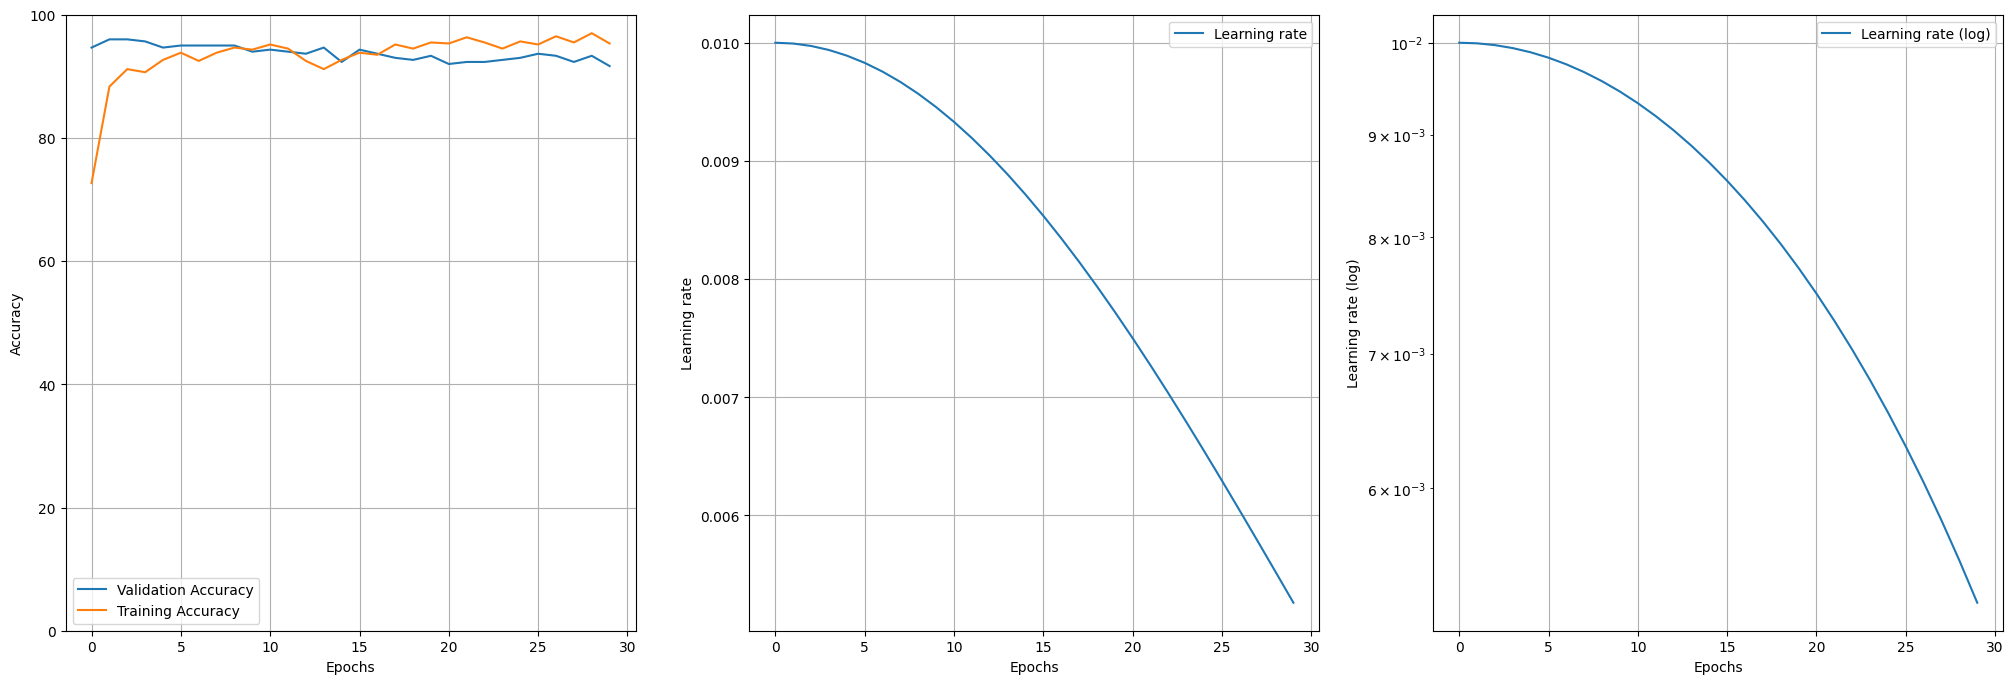

Test Accuracy: 94.67%


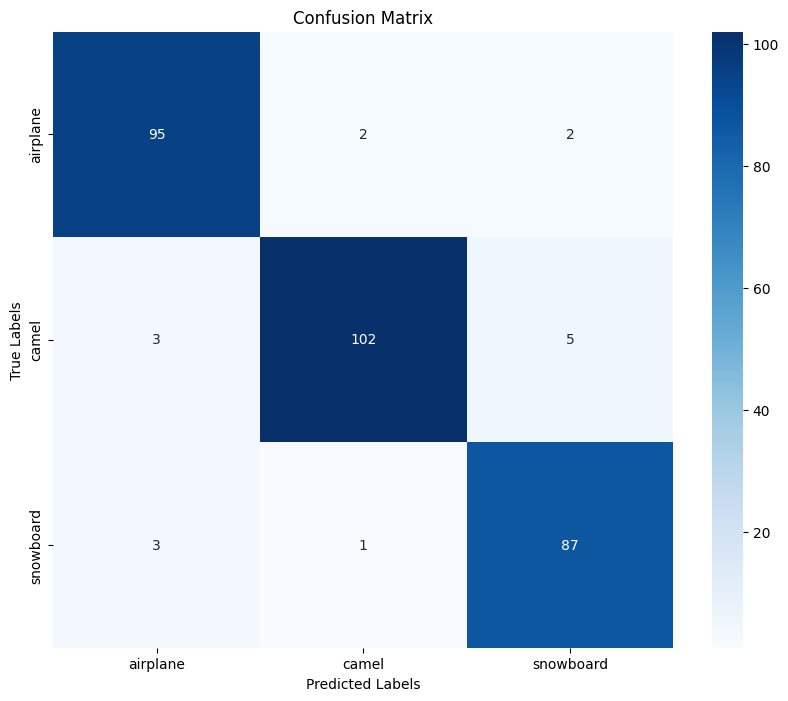

Classification Metrics (Tabular Form):


,precision,recall,f1-score,support
airplane,0.940594,0.959596,0.950000,99.000000
camel,0.971429,0.927273,0.948837,110.000000
snowboard,0.925532,0.956044,0.940541,91.000000
accuracy,0.946667,0.946667,0.946667,0.946667
macro avg,0.945852,0.947638,0.946459,300.000000
weighted avg,0.947331,0.946667,0.946704,300.000000


<Figure size 1000x600 with 0 Axes>

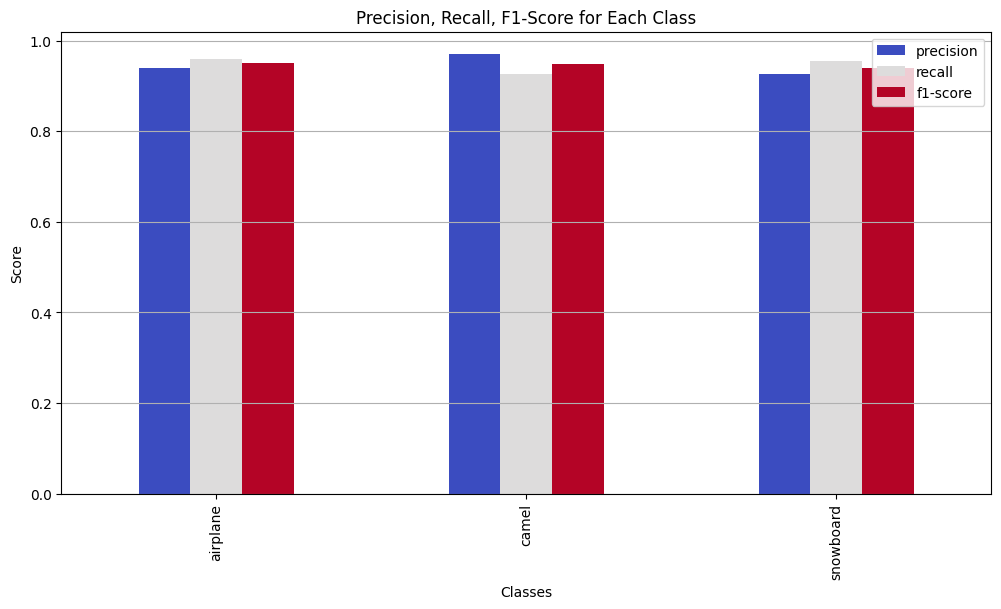

In [15]:
# testing after training with every convolutional layer freezed
test(train_accs, val_accs, lrs, epoch+1)

In [16]:
# unfreeze the last two convolutional layers
if cfg.model == "mobilenet_v3_small" and not cfg.dont_freeze:
    for param in model.features[:-2].parameters():
        param.requires_grad = True
        
if cfg.model == "resnet50" and not cfg.dont_freeze:
    for param in model.layer4.parameters():
        param.requires_grad = True
# training the model with the last two convolutional layers unfreezed
train_accs, val_accs, lrs, epoch = train(train_accs=train_accs, val_accs=val_accs, lrs=lrs, epochparam=epoch)

Epoch [1/30], Train Loss: 0.1002, Train Accuracy: 96.33%, Val Loss: 0.3163, Val Accuracy: 87.33%, LR: 0.00500
Epoch [2/30], Train Loss: 0.1170, Train Accuracy: 96.00%, Val Loss: 0.6053, Val Accuracy: 79.33%, LR: 0.00474
Epoch [3/30], Train Loss: 0.1426, Train Accuracy: 95.17%, Val Loss: 0.4940, Val Accuracy: 82.00%, LR: 0.00448
Epoch [4/30], Train Loss: 0.1286, Train Accuracy: 94.67%, Val Loss: 0.4240, Val Accuracy: 85.33%, LR: 0.00422
Epoch [5/30], Train Loss: 0.0773, Train Accuracy: 97.67%, Val Loss: 0.3930, Val Accuracy: 88.33%, LR: 0.00396
Epoch [6/30], Train Loss: 0.1107, Train Accuracy: 96.00%, Val Loss: 0.3698, Val Accuracy: 88.33%, LR: 0.00371
Epoch [7/30], Train Loss: 0.0891, Train Accuracy: 96.83%, Val Loss: 0.3331, Val Accuracy: 88.67%, LR: 0.00345
Epoch [8/30], Train Loss: 0.0600, Train Accuracy: 98.17%, Val Loss: 0.3260, Val Accuracy: 89.67%, LR: 0.00321
Epoch [9/30], Train Loss: 0.0622, Train Accuracy: 98.00%, Val Loss: 0.2763, Val Accuracy: 90.33%, LR: 0.00297
Epoch [10/

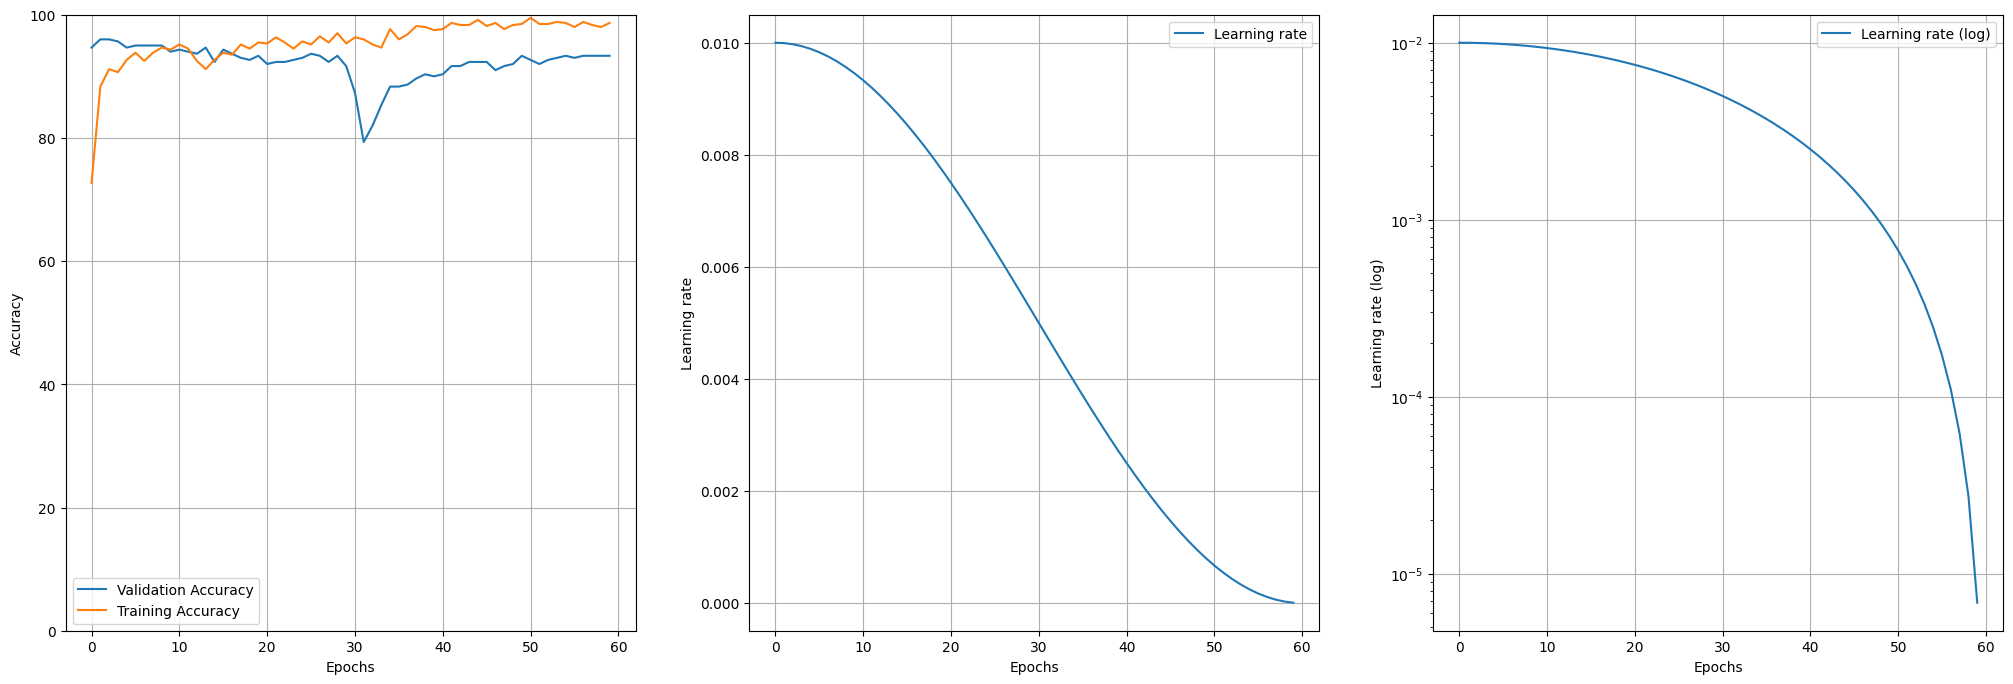

Test Accuracy: 90.67%


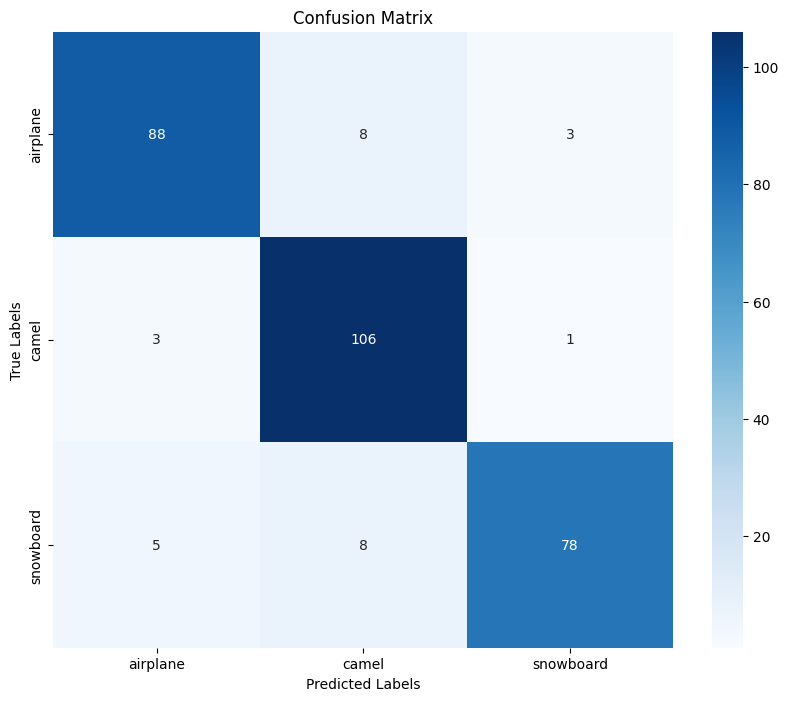

Classification Metrics (Tabular Form):


,precision,recall,f1-score,support
airplane,0.916667,0.888889,0.902564,99.000000
camel,0.868852,0.963636,0.913793,110.000000
snowboard,0.951220,0.857143,0.901734,91.000000
accuracy,0.906667,0.906667,0.906667,0.906667
macro avg,0.912246,0.903223,0.906030,300.000000
weighted avg,0.909616,0.906667,0.906430,300.000000


<Figure size 1000x600 with 0 Axes>

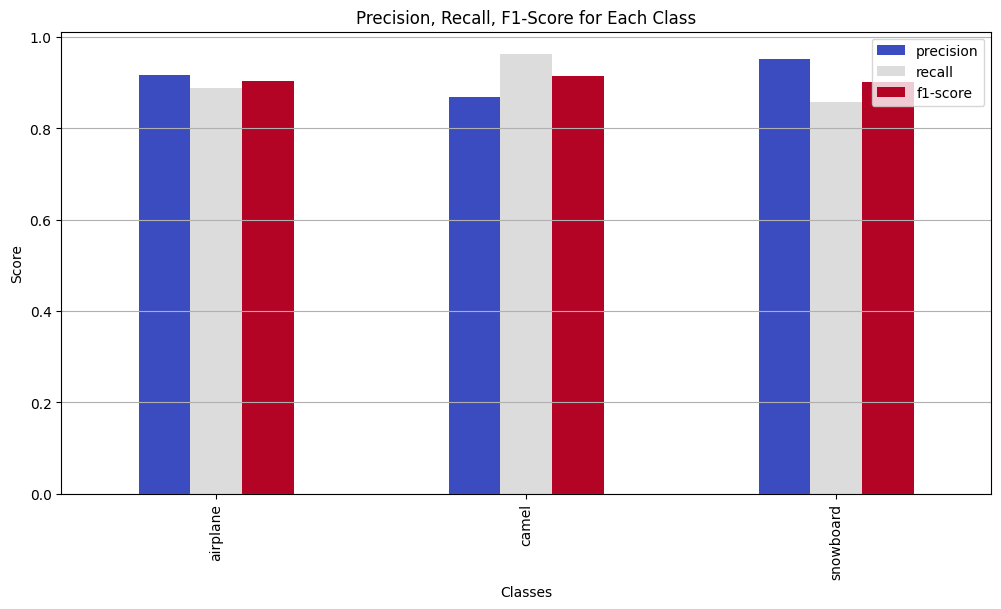

In [17]:
# testing after training with the last two convolutional layers unfreezed
test(train_accs, val_accs, lrs, epochnum=epoch+2, last_test=True)

# Hyperparameter optimalization part

In this section I tried to hyperopt the model. The following parameters considered:
- dropout coefficient
- if we freeze the layers or not
- the value of a constant learning rate
- the optimizer


In [18]:
# Function to create the model with suggested values from optuna
def create_model(trial):
    if cfg.model == "mobilenet_v3_small":
        model = models.mobilenet_v3_small(pretrained=True)
        model.classifier[3] = nn.Sequential(
            nn.Dropout(trial.suggest_uniform("dropout", 0.2, 0.5)),
            nn.Linear(model.classifier[3].in_features, cfg.num_classes)
        )
        
        if trial.suggest_categorical("freeze_features", [True, False]):
            for param in model.features.parameters():
                param.requires_grad = False
    
    
    elif cfg.model == "resnet50":
        model = models.resnet50(pretrained=True)
        model.fc = nn.Sequential(
            nn.Dropout(trial.suggest_uniform("dropout", 0.2, 0.5)),
            nn.Linear(model.fc.in_features, cfg.num_classes)
        )
        
        if trial.suggest_categorical("freeze_layer4", [True, False]):
            for param in model.layer4.parameters():
                param.requires_grad = False
    
    
    else:
        raise NotImplementedError("Unknown model specified!")

    return model.to(cfg.device)

In [19]:
# the objective function for optune, in which we train and validate the models
def objective(trial):
    # refresh the model to the current trial
    model = create_model(trial)

    # make an optimizer for the current trial
    optimizer_name = trial.suggest_categorical("optimizer", ["SGD", "Adam", "AdamW"])
    # suggest a learning rate
    lr = trial.suggest_uniform("lr", 1e-5, 1e-2)
    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr)

    criterion = nn.CrossEntropyLoss()

    # a simple training loop, we don't need the training accuracies and such
    for epoch in range(cfg.hyperopt_epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(cfg.device), labels.to(cfg.device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # finally validate the model
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(cfg.device), labels.to(cfg.device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()

    return val_loss / len(val_loader)

In [20]:
# run the optuna optimizer
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# print the best values
print("Best hyperparameters:", study.best_params)
print("Best validation loss:", study.best_value)

# save the values in a .txt file
with open("optuna_results.txt", "w") as f:
    for trial in study.trials:
        f.write(f"Trial {trial.number}:\n")
        f.write(f"  Params: {trial.params}\n")
        f.write(f"  Value: {trial.value}\n")
        f.write(f"  State: {trial.state}\n")
        f.write("\n")
        # also print them to the console
        print(f"Trial {trial.number}:")
        print(f"  Params: {trial.params}")
        print(f"  Validation Loss: {trial.value}")
    f.write("\nBest trial:\n")
    f.write(f"  Params: {study.best_params}\n")
    f.write(f"  Value: {study.best_value}\n")

best_params = study.best_params
print("Best hyperparameters:", best_params)


[I 2024-12-03 11:36:48,529] A new study created in memory with name: no-name-6e204ebd-bc24-4d85-aab1-0d989d62fb81
/home/pongvins/miniconda3/envs/depphw/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pongvins/miniconda3/envs/depphw/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_110542/4273581205.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/ta

KeyboardInterrupt: 

In [21]:
# visualise the trials with the optuna.visualization module

vis.plot_optimization_history(study).show()
vis.plot_param_importances(study).show()